# Final Assignment

## Find the optimal place to open a new beergarden in Munich

### Import necessary libraries

In [1]:
import pandas as pd
import folium # map rendering library
import requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
import numpy as np


### Input Data gathering and preparation

In [2]:
#Scrape the information on Munich districts from the Wikipedia page
districts = pd.read_html('https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens')
districts =  districts[0]
districts = districts.drop(districts[districts.Stadtbezirk == 'Landeshauptstadt München'].index)

#Drop unnecessary information
districts = districts.drop(['Fläche(km²)', 'Dichte(Einw./km²)', 'Ausländer(%)', 'Nr.'], axis=1)

#Rename all german column headers which were automatically derived
districts = districts.rename(columns={"Stadtbezirk":"District", "Einwohner":"Inhabitants"})

#As geopy was not always able to determine the correct coordinates for some district names I always added "München" to each district
districts['new']= 'München '
districts['District_Geopy']= districts['new']+districts['District']
districts = districts.drop(['new'], axis=1)
districts['Inhabitants'] = districts['Inhabitants'].astype('float')
districts

,District,Inhabitants,District_Geopy
0,Altstadt-Lehel,21.100,München Altstadt-Lehel
1,Ludwigsvorstadt-Isarvorstadt,51.644,München Ludwigsvorstadt-Isarvorstadt
2,Maxvorstadt,51.402,München Maxvorstadt
3,Schwabing-West,68.527,München Schwabing-West
4,Au-Haidhausen,61.356,München Au-Haidhausen
5,Sendling,40.983,München Sendling
6,Sendling-Westpark,59.643,München Sendling-Westpark
7,Schwanthalerhöhe,29.743,München Schwanthalerhöhe
8,Neuhausen-Nymphenburg,98.814,München Neuhausen-Nymphenburg
9,Moosach,54.223,München Moosach


### Determination of geo data

In [59]:
#Determine Latitude and Longitude for all districts
column_names = ['District', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

for name in districts['District_Geopy']:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(name)
    latitude = location.latitude
    longitude = location.longitude
    neighborhoods = neighborhoods.append({'District': name,
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)
  
#Remove the leading "München" used for the Geopy query
neighborhoods["District"]=neighborhoods["District"].str[8:]
neighborhoods

,District,Latitude,Longitude
0,Altstadt-Lehel,48.139656,11.587921
1,Ludwigsvorstadt-Isarvorstadt,48.130340,11.573366
2,Maxvorstadt,48.149555,11.567753
3,Schwabing-West,48.168271,11.569873
4,Au-Haidhausen,48.128753,11.590536
5,Sendling,48.124588,11.512817
6,Sendling-Westpark,48.124588,11.512817
7,Schwanthalerhöhe,48.133782,11.541057
8,Neuhausen-Nymphenburg,48.157124,11.509703
9,Moosach,48.180166,11.506122


## Foursquare data gathering

In [4]:
# Credentials to Foursquare Api
CLIENT_ID = 'BPZMZ0RXGCRUADPMCWZWR4FAWL3KBQJT2YAWLZTMIY2TQ4HG' # your Foursquare ID
CLIENT_SECRET = 'TAQGMGWHSH5THUDAWPYU10PJJIUGPMDPTOLRZ4FXMBFX4FCK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: BPZMZ0RXGCRUADPMCWZWR4FAWL3KBQJT2YAWLZTMIY2TQ4HG
CLIENT_SECRET:TAQGMGWHSH5THUDAWPYU10PJJIUGPMDPTOLRZ4FXMBFX4FCK


In [74]:
#Function to get the venues in a radius of 2000m around the coordinates of each district
def getNearbyVenues(names, latitudes, longitudes, category, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #category = category    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            category,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print('Venues succesfully gathered for district: ',name) 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [75]:
# Call the function for all districts
LIMIT=100
munich_beergarden = getNearbyVenues(names=neighborhoods['District'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   category= '4d4b7105d754a06374d81259'
                                  )

Venues succesfully gathered for district:  Altstadt-Lehel
Venues succesfully gathered for district:  Ludwigsvorstadt-Isarvorstadt
Venues succesfully gathered for district:  Maxvorstadt
Venues succesfully gathered for district:  Schwabing-West
Venues succesfully gathered for district:  Au-Haidhausen
Venues succesfully gathered for district:  Sendling
Venues succesfully gathered for district:  Sendling-Westpark
Venues succesfully gathered for district:  Schwanthalerhöhe
Venues succesfully gathered for district:  Neuhausen-Nymphenburg
Venues succesfully gathered for district:  Moosach
Venues succesfully gathered for district:  Milbertshofen-Am Hart
Venues succesfully gathered for district:  Schwabing-Freimann
Venues succesfully gathered for district:  Bogenhausen
Venues succesfully gathered for district:  Berg am Laim
Venues succesfully gathered for district:  Trudering-Riem
Venues succesfully gathered for district:  Ramersdorf-Perlach
Venues succesfully gathered for district:  Obergiesin

### Data preparation for K-means clustering

In [49]:
# one hot encoding
munich_onehot = pd.get_dummies(munich_beergarden[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
munich_onehot['District'] = munich_beergarden['District'] 

# move neighborhood column to the first column
fixed_columns = [munich_onehot.columns[-1]] + list(munich_onehot.columns[:-1])
munich_onehot = munich_onehot[fixed_columns]

munich_onehot.head()

,District,Afghan Restaurant,American Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bavarian Restaurant,Bistro,...,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Thai Restaurant,Theme Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Altstadt-Lehel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Normalization by mean calculation
munich_grouped = munich_onehot.groupby('District').mean().reset_index()
munich_grouped

,District,Afghan Restaurant,American Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bavarian Restaurant,Bistro,...,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Thai Restaurant,Theme Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Allach-Untermenzing,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.266667,0.133333,0.000000,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.133333,0.066667,0.00,0.066667
1,Altstadt-Lehel,0.02,0.000000,0.010000,0.010000,0.000000,0.00,0.020000,0.100000,0.020000,...,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.020000,0.000000,0.01,0.000000
2,Au-Haidhausen,0.02,0.000000,0.000000,0.000000,0.000000,0.00,0.030000,0.050000,0.040000,...,0.000000,0.00,0.00,0.010000,0.020000,0.000000,0.020000,0.010000,0.02,0.020000
3,Aubing-Lochhausen-Langwied,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.333333,0.000000,0.111111,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Berg am Laim,0.00,0.000000,0.050847,0.016949,0.000000,0.00,0.135593,0.016949,0.000000,...,0.000000,0.00,0.00,0.000000,0.033898,0.000000,0.016949,0.000000,0.00,0.016949
5,Bogenhausen,0.00,0.000000,0.063492,0.000000,0.015873,0.00,0.222222,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.015873,0.000000,0.015873,0.000000,0.00,0.000000
6,Feldmoching-Hasenbergl,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.210526,0.000000,0.000000,...,0.000000,0.00,0.00,0.052632,0.052632,0.000000,0.052632,0.000000,0.00,0.000000
7,Hadern,0.00,0.000000,0.058824,0.000000,0.000000,0.00,0.205882,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.058824,0.000000,0.00,0.029412
8,Laim,0.00,0.013514,0.013514,0.000000,0.000000,0.00,0.162162,0.000000,0.013514,...,0.013514,0.00,0.00,0.000000,0.013514,0.000000,0.013514,0.000000,0.00,0.000000
9,Ludwigsvorstadt-Isarvorstadt,0.02,0.000000,0.020000,0.000000,0.000000,0.00,0.010000,0.090000,0.020000,...,0.000000,0.00,0.01,0.010000,0.000000,0.000000,0.000000,0.000000,0.01,0.030000


### Determine the optimal number of clusters

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [51]:
max_range = 20 # Maximum range of clusters

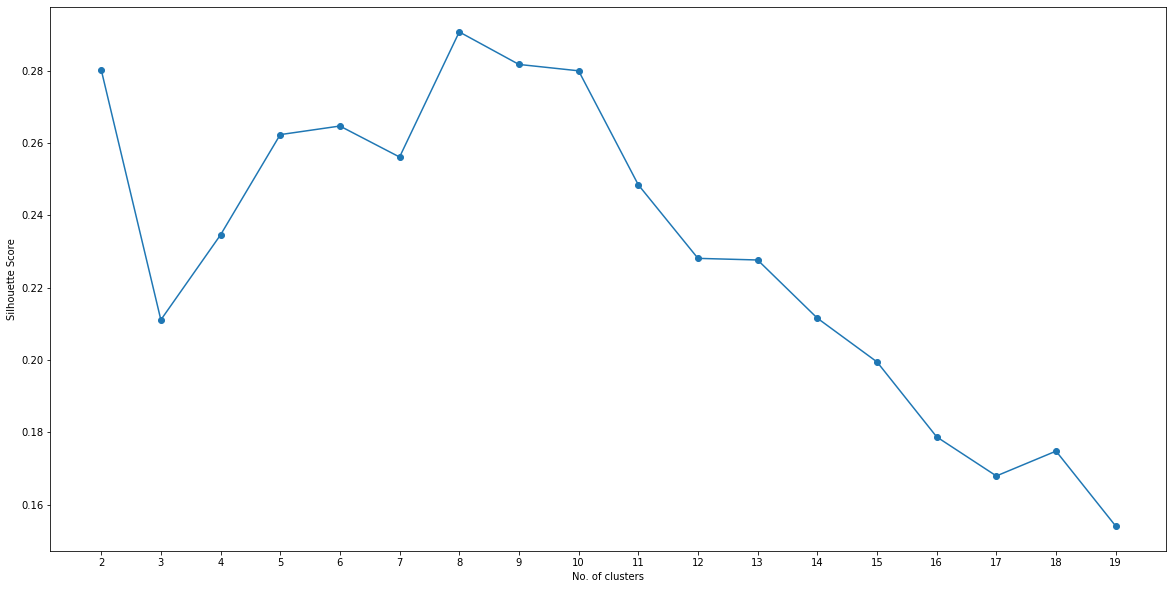

In [54]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kgc = munich_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [45]:
# Find the optimal value of clusters
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

8

### Fit K-means with the optimal number of clusters

In [46]:
# set number of clusters
kclusters = opt

munich_grouped_clustering = munich_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(munich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([4, 0, 0, 5, 6, 6, 1, 1, 6, 0])

In [47]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


ValueError: cannot insert Cluster Labels, already exists

### Merge districts with Cluster information

In [62]:
munich_merged = districts

munich_merged = munich_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

munich_merged # check the last columns!

,District,Inhabitants,District_Geopy,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstadt-Lehel,21.100,München Altstadt-Lehel,1,Café,German Restaurant,Italian Restaurant,Bavarian Restaurant,Restaurant,Pizza Place,Steakhouse,Indian Restaurant,Afghan Restaurant,Sandwich Place
1,Ludwigsvorstadt-Isarvorstadt,51.644,München Ludwigsvorstadt-Isarvorstadt,1,Café,German Restaurant,Bavarian Restaurant,Italian Restaurant,Pizza Place,Restaurant,Vietnamese Restaurant,Seafood Restaurant,Asian Restaurant,Bistro
2,Maxvorstadt,51.402,München Maxvorstadt,1,Café,German Restaurant,Italian Restaurant,Restaurant,Bakery,Vietnamese Restaurant,Bavarian Restaurant,Steakhouse,Asian Restaurant,Trattoria/Osteria
3,Schwabing-West,68.527,München Schwabing-West,1,Café,Italian Restaurant,Vietnamese Restaurant,Greek Restaurant,Restaurant,Trattoria/Osteria,Thai Restaurant,Bakery,German Restaurant,Gastropub
4,Au-Haidhausen,61.356,München Au-Haidhausen,1,Café,German Restaurant,Italian Restaurant,Bavarian Restaurant,Restaurant,Pizza Place,Bistro,Steakhouse,Bakery,Seafood Restaurant
5,Sendling,40.983,München Sendling,4,Italian Restaurant,Bakery,Greek Restaurant,Asian Restaurant,Turkish Restaurant,German Restaurant,Bavarian Restaurant,Sushi Restaurant,Steakhouse,Caucasian Restaurant
6,Sendling-Westpark,59.643,München Sendling-Westpark,4,Italian Restaurant,Bakery,Greek Restaurant,Asian Restaurant,Turkish Restaurant,German Restaurant,Bavarian Restaurant,Sushi Restaurant,Steakhouse,Caucasian Restaurant
7,Schwanthalerhöhe,29.743,München Schwanthalerhöhe,1,Café,German Restaurant,Asian Restaurant,Italian Restaurant,Bavarian Restaurant,Vietnamese Restaurant,Trattoria/Osteria,Pizza Place,Sushi Restaurant,Bistro
8,Neuhausen-Nymphenburg,98.814,München Neuhausen-Nymphenburg,0,Bakery,Italian Restaurant,Café,German Restaurant,Greek Restaurant,Restaurant,Trattoria/Osteria,Pizza Place,Asian Restaurant,Doner Restaurant
9,Moosach,54.223,München Moosach,2,Bakery,Fast Food Restaurant,Café,Asian Restaurant,Italian Restaurant,German Restaurant,Doner Restaurant,Trattoria/Osteria,Deli / Bodega,Restaurant


### Determine the number of beergardens

In [76]:
#Determine all beergardens in the districts

# Call the function for all districts gathering the beergardens in a district from Foursquare
LIMIT=100
munich_beergarden = getNearbyVenues(names=neighborhoods['District'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   category= '4bf58dd8d48988d117941735'
                                  )

Venues succesfully gathered for district:  Altstadt-Lehel
Venues succesfully gathered for district:  Ludwigsvorstadt-Isarvorstadt
Venues succesfully gathered for district:  Maxvorstadt
Venues succesfully gathered for district:  Schwabing-West
Venues succesfully gathered for district:  Au-Haidhausen
Venues succesfully gathered for district:  Sendling
Venues succesfully gathered for district:  Sendling-Westpark
Venues succesfully gathered for district:  Schwanthalerhöhe
Venues succesfully gathered for district:  Neuhausen-Nymphenburg
Venues succesfully gathered for district:  Moosach
Venues succesfully gathered for district:  Milbertshofen-Am Hart
Venues succesfully gathered for district:  Schwabing-Freimann
Venues succesfully gathered for district:  Bogenhausen
Venues succesfully gathered for district:  Berg am Laim
Venues succesfully gathered for district:  Trudering-Riem
Venues succesfully gathered for district:  Ramersdorf-Perlach
Venues succesfully gathered for district:  Obergiesin

### Prepare the necessary information

In [108]:
count_beergarden = munich_beergarden.groupby('District').count()
count_beergarden['Count_beergardens']=count_beergarden['Venue']
count_beergarden = count_beergarden.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1)

final_result = munich_merged[['District', 'Cluster Labels', 'Inhabitants']].copy()

final_result = final_result.merge(count_beergarden, left_on='District', right_on='District')
final_result['Beergaden_per_10K']= round(final_result['Count_beergardens']/final_result['Inhabitants']*10,1)
final_result = final_result.sort_values(by=['Beergaden_per_10K'], ignore_index=True)
final_result

,District,Cluster Labels,Inhabitants,Count_beergardens,Beergaden_per_10K
0,Aubing-Lochhausen-Langwied,2,47.813,1,0.2
1,Hadern,2,49.898,1,0.2
2,Ramersdorf-Perlach,1,116.327,2,0.2
3,Milbertshofen-Am Hart,0,75.094,2,0.3
4,Pasing-Obermenzing,3,74.625,3,0.4
5,Thalkirchen-Obersendling-Forstenried-Fürstenri...,3,96.714,4,0.4
6,Obergiesing-Fasangarten,3,54.256,2,0.4
7,Trudering-Riem,0,73.206,3,0.4
8,Feldmoching-Hasenbergl,3,61.774,3,0.5
9,Bogenhausen,0,87.950,5,0.6


In [105]:
#Read GeoJson File
munich_geo = r'munich.geojson'
world_map = folium.Map(location=[latitude, longitude], zoom_start=11)


folium.Choropleth(
    geo_data=munich_geo,
    data=final_result,
    columns=['District', 'Beergaden_per_10K'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    legend_name='Restaurant/100,000 Inhabitants'
).add_to(world_map)

#folium.Choropleth.geojson.add_child(
folium.features.GeoJsonTooltip(['District'])


# display map
world_map

In [109]:
munich_merged.loc[munich_merged['Cluster Labels'] == 1]

,District,Inhabitants,District_Geopy,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstadt-Lehel,21.100,München Altstadt-Lehel,1,Café,German Restaurant,Italian Restaurant,Bavarian Restaurant,Restaurant,Pizza Place,Steakhouse,Indian Restaurant,Afghan Restaurant,Sandwich Place
1,Ludwigsvorstadt-Isarvorstadt,51.644,München Ludwigsvorstadt-Isarvorstadt,1,Café,German Restaurant,Bavarian Restaurant,Italian Restaurant,Pizza Place,Restaurant,Vietnamese Restaurant,Seafood Restaurant,Asian Restaurant,Bistro
2,Maxvorstadt,51.402,München Maxvorstadt,1,Café,German Restaurant,Italian Restaurant,Restaurant,Bakery,Vietnamese Restaurant,Bavarian Restaurant,Steakhouse,Asian Restaurant,Trattoria/Osteria
3,Schwabing-West,68.527,München Schwabing-West,1,Café,Italian Restaurant,Vietnamese Restaurant,Greek Restaurant,Restaurant,Trattoria/Osteria,Thai Restaurant,Bakery,German Restaurant,Gastropub
4,Au-Haidhausen,61.356,München Au-Haidhausen,1,Café,German Restaurant,Italian Restaurant,Bavarian Restaurant,Restaurant,Pizza Place,Bistro,Steakhouse,Bakery,Seafood Restaurant
7,Schwanthalerhöhe,29.743,München Schwanthalerhöhe,1,Café,German Restaurant,Asian Restaurant,Italian Restaurant,Bavarian Restaurant,Vietnamese Restaurant,Trattoria/Osteria,Pizza Place,Sushi Restaurant,Bistro
15,Ramersdorf-Perlach,116.327,München Ramersdorf-Perlach,1,Greek Restaurant,German Restaurant,Italian Restaurant,Café,Bavarian Restaurant,Diner,Poke Place,Restaurant,Chinese Restaurant,Trattoria/Osteria
